# LINEAR SVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import libsvm
from libsvm.svmutil import *

help(svm_predict)

%matplotlib inline

Help on function svm_predict in module libsvm.svmutil:

svm_predict(y, x, m, options='')
    svm_predict(y, x, m [, options]) -> (p_labels, p_acc, p_vals)
    
    y: a list/tuple/ndarray of l true labels (type must be int/double).
       It is used for calculating the accuracy. Use [] if true labels are
       unavailable.
    
    x: 1. a list/tuple of l training instances. Feature vector of
          each training instance is a list/tuple or dictionary.
    
       2. an l * n numpy ndarray or scipy spmatrix (n: number of features).
    
    Predict data (y, x) with the SVM model m.
    options:
        -b probability_estimates: whether to predict probability estimates,
            0 or 1 (default 0); for one-class SVM only 0 is supported.
        -q : quiet mode (no outputs).
    
    The return tuple contains
    p_labels: a list of predicted labels
    p_acc: a tuple including  accuracy (for classification), mean-squared
           error, and squared correlation coefficient (for 

## 3.1 Linear Support Vector Machine on toy data

### 3.1.1 
Generate a training set of size $100$ with 2D features (X) drawn at random as follows:
* X_{neg} $\sim$ $\mathcal{N}$([-5, -5], 5*$I_2$) and correspond to negative labels (-1)
* X_{pos} $\sim$ $\mathcal{N}$([5, 5], 5*$I_2$) and correspond to positive labels (+1)
<br />
Accordingly, $X = [X_{neg}, X_{pos}]$ is a $100\times2$ array, Y is a $100\times1$ array of values $\in \{-1, 1\}$.
<p/>Draw a scatter plot of the full training dataset with the points colored according to their labels.

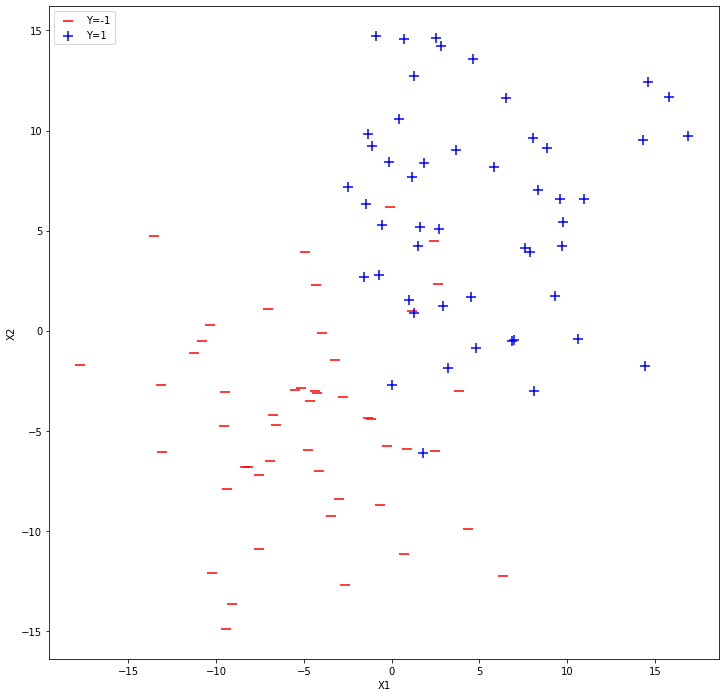

In [2]:
# Generate binary class dataset
np.random.seed(0)

n_samples = 100
center_1 = [-5, -5]
center_2 = [5, 5]

# Generate Data:
# generate normals independently, since no covariance
Xneg = np.array([np.array([np.random.normal(-5, 5), np.random.normal(-5,5)]) for i in range(50)])
Xpos = np.array([np.array([np.random.normal(5, 5), np.random.normal(5,5)]) for i in range(50)])
X = np.array([obs for obs in Xneg] + [obs for obs in Xpos])
Y = [-1]*50 + [1]*50

# Scatter plot:
# plt.scatter(X[:,0], X[:,1], c=Y)
# graphing separately to add nice labels
plt.figure(figsize=(12,12))
plt.scatter(X[:50,0], X[:50,1], c='r', marker = "_", label='Y=-1', s=100)
plt.scatter(X[50:,0], X[50:,1], c='b', marker = "+", label='Y=1', s=100)
plt.legend(loc='upper left')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### 3.1.2 
Train a linear support vector machine on the data with $C=1$ and draw the decision boundary line that separates o and x. Mark the support vectors separately (ex.circle around the point). 

Note: You can use the libsvm.svmutil functions with the kernel_type set to 0, indiciating a linear kernel and svm_type set to 0 indicating C-SVC.
Also note that the support_vector coefficients returned by the LIBSVM model are the dual coefficients.

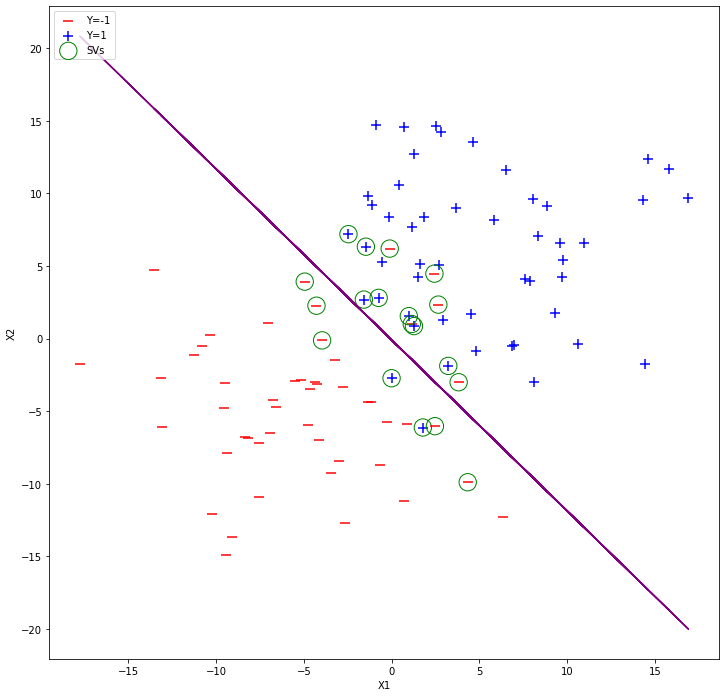

In [22]:
# Define the SVM problem
problem = svm_problem(Y, X)

# Define the hyperparameters
C=1
params = svm_parameter('-s 0 -t 0 -c '+ str(C))

# Train the model
m = svm_train(problem, params)

# Compute the slope and intercept of the separating line/hyperplanee with the use of the support vectors
# and other information from the LIBSVM model.
# set intercept first
coefs = [-m.rho.contents.value] + [0]*len(X[0])

# get support vectors (the only points that have nonzero alpha)
supp_vecs = np.array([np.array([sv[i] for i in sv.keys()]) for sv in m.get_SV()])
dual_coefs = np.array([alpha[0] for alpha in m.get_sv_coef()])

for i in range(len(supp_vecs)):
    for k in range(len(supp_vecs[i])):
        coefs[k+1] = coefs[k+1] + supp_vecs[i][k]*dual_coefs[i]
        
# Draw the scatter plot, the decision boundary line, and mark the support vectors.
# solve for feature 2 in terms of feature 1
x1 = []
x2 = []
for i in range(len(X)):
    # original x values
    x1.append(X[i][0])
    
    # decision boundary points at each x value
    x2.append(-(coefs[1]/coefs[2])*x1[i] - (coefs[0]/coefs[2]))

# the support vectors/misclassifications
supp_vecs_x = []
supp_vecs_y = []
for sv in supp_vecs:
    supp_vecs_x.append(sv[0])
    supp_vecs_y.append(sv[1])

plt.figure(figsize=(12,12))

plt.plot(x1,x2, color='purple')
plt.scatter(Xneg[:,0], Xneg[:,1], c='r', marker = "_", label='Y=-1', s=100)
plt.scatter(Xpos[:,0], Xpos[:,1], c='b', marker = "+", label='Y=1', s=100)

plt.scatter(supp_vecs_x, supp_vecs_y, edgecolors='g', marker='o',facecolors='none', label="SVs", s=300)

plt.legend(loc='upper left')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### 3.1.3 
Draw a line that separates the data for 8 different $C$ ($10^{-5}$~$10^7$).
Plot the number of support vectors vs. $C$ (plot x-axis on a log scale).
How does the number of support vectors change as $C$ increases and why does it change like that? 

Note: You might prefer to use the command-line style of svm_parameter initialization such as: svm_parameter('-s 0 -t 0') to indicate a linear kernel and C-SVC as the SVM type.


My answer: The number of support vectors decreases as $C$ becomes large because the cost of violating the constraint increases. Thus, for each increase in $C$, the margin becomes smaller, and so fewer examples fall between the observations.

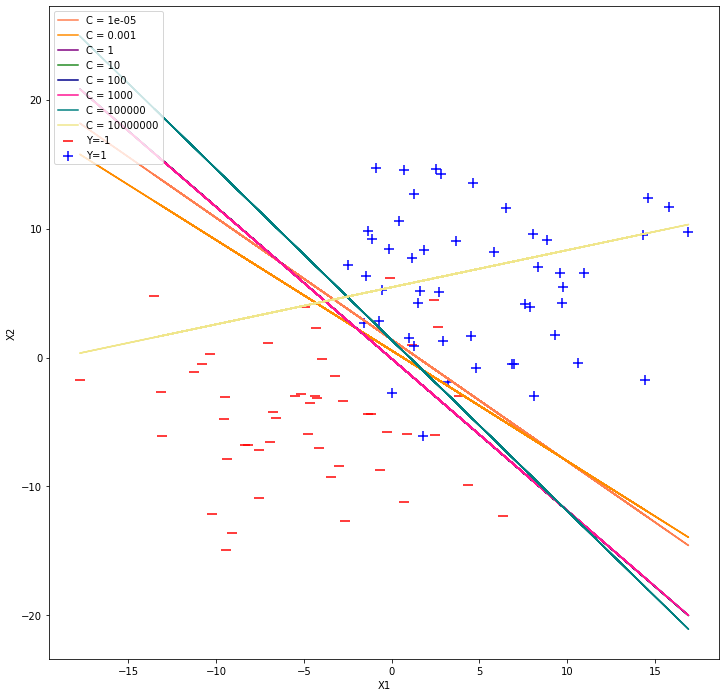

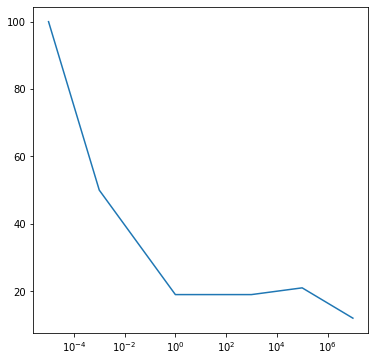

In [23]:
C_range = [10**-5, 10**-3, 1, 10, 100, 10**3, 10**5, 10**7]
num_sv = []

# for colors
iters = 0
colors = ['coral', 'darkorange', 'purple', 'forestgreen', 'darkblue', 'deeppink', 'teal', 'khaki']

plt.figure(figsize=(12,12))
problem = svm_problem(Y,X)

# Loop over a similar setup to that in the previous code block.
for C in C_range:
    params = svm_parameter('-s 0 -t 0 -c '+ str(C))

    # Train the model
    m = svm_train(problem, params)

    # Compute the slope and intercept of the separating line/hyperplanee with the use of the support vectors
    # and other information from the LIBSVM model.
    # set intercept first
    coefs = [-m.rho.contents.value] + [0]*len(X[0])

    # get support vectors (the only points that have nonzero alpha)
    supp_vecs = np.array([np.array([sv[i] for i in sv.keys()]) for sv in m.get_SV()])
    dual_coefs = np.array([alpha[0] for alpha in m.get_sv_coef()])
    
    num_sv.append(len(supp_vecs))
    
    for i in range(len(supp_vecs)):
        for k in range(len(supp_vecs[i])):
            coefs[k+1] = coefs[k+1] + supp_vecs[i][k]*dual_coefs[i]

    # Draw the scatter plot, the decision boundary line, and mark the support vectors.
    # solve for feature 2 in terms of feature 1
    x1 = []
    x2 = []
    for i in range(len(X)):
        x1.append(X[i][0])
        x2.append(-(coefs[1]/coefs[2])*x1[i] - (coefs[0]/coefs[2]))

    plt.plot(x1,x2, color=colors[iters], label='C = ' + str(C))
    iters = iters + 1

# Draw the scatter plot with multiple decision lines on top (one for each value of C)
plt.scatter(Xneg[:,0], Xneg[:,1], c='r', marker = "_", label='Y=-1', s=100)
plt.scatter(Xpos[:,0], Xpos[:,1], c='b', marker = "+", label='Y=1', s=100)
plt.legend(loc='upper left')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Draw the num_sv vs. C plot.
plt.figure(figsize=(6,6))
plt.plot(C_range, num_sv)
plt.xscale('log')
plt.show()

### 3.1.4 
Now try rescaling the data to the [0,1] range and repeat the steps of the previous question (3.1.3) and over the same range of $C$ values. Are the decision boundaries different from those in the previous question? What does this imply about (a) the geometric margin and (b) the relative effect of each feature on the predictions of the trained model ?

#### Solution below: 
SVM tries to maximize the distance between the separating plane and the support vectors. 
If one feature (i.e. one dimension in this space) has very large values, 
it will dominate the other features when calculating the distance. If you rescale all 
features (e.g. to [0, 1]), they all have the same influence on the distance metric.



In [ ]:
import sklearn
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

# Single line below:
X_train_minmax = min_max_scaler.fit_transform(X)

In [ ]:
C_range = [10**-5, 10**-3, 1, 10, 100, 10**3, 10**5, 10**7]
num_sv = []

# for colors
iters = 0
colors = ['coral', 'darkorange', 'purple', 'forestgreen', 'darkblue', 'deeppink', 'teal', 'khaki']

plt.figure(figsize=(12,12))
problem = svm_problem(Y,X_train_minmax)

# Loop over a similar setup to that in the previous code block.
for C in C_range:
    params = svm_parameter('-s 0 -t 0 -c '+ str(C))

    # Train the model
    m = svm_train(problem, params)

    # Compute the slope and intercept of the separating line/hyperplanee with the use of the support vectors
    # and other information from the LIBSVM model.
    # set intercept first
    coefs = [-m.rho.contents.value] + [0]*len(X_train_minmax[0])

    # get support vectors (the only points that have nonzero alpha)
    supp_vecs = np.array([np.array([sv[i] for i in sv.keys()]) for sv in m.get_SV()], dtype=object)
    dual_coefs = np.array([alpha[0] for alpha in m.get_sv_coef()])
    
    # add number of support vectors to list
    num_sv.append(len(supp_vecs))
    
    # calculate coefficients using the formula
    for i in range(len(supp_vecs)):
        for k in range(len(supp_vecs[i])):
            coefs[k+1] = coefs[k+1] + supp_vecs[i][k]*dual_coefs[i]

    # Draw the scatter plot, the decision boundary line, and mark the support vectors.
    # solve for feature 2 in terms of feature 1
    x1 = []
    x2 = []
    for i in range(len(X_train_minmax)):
        x1.append(X_train_minmax[i][0])
        x2.append(-(coefs[1]/coefs[2])*x1[i] - (coefs[0]/coefs[2]))
    
    # add line to plot
    plt.plot(x1,x2, color=colors[iters], label='C = ' + str(C))
    iters = iters + 1

# Draw the scatter plot with multiple decision lines on top (one for each value of C)
plt.scatter(X_train_minmax[:50,0], X_train_minmax[:50,1], c='r', marker = "_", label='Y=-1', s=100)
plt.scatter(X_train_minmax[50:,0], X_train_minmax[50:,1], c='b', marker = "+", label='Y=1', s=100)
plt.legend(loc='upper left')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Draw the num_sv vs. C plot.
plt.figure(figsize=(6,6))
plt.plot(C_range, num_sv)
plt.xscale('log')
plt.show()

## *Penguins*

Multiclass SVM. In this problem, we will use support vector machines to classify penguins species based on the given features.

Load in the penguins data using from the provided penguins.csv file on Sakai. Preprocess the features. Then we will use the train_test_split from sklearn to split the data into training and testing into a 0.8 : 0.2 ratio.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# load data
df = pd.read_csv('../../Datasets/penguins.csv')
df = df.dropna()

# one vs all as 0 vs rest
target = df.loc[:,'Species'].apply(lambda s: 1 if s == 0 else -1)
df['Target'] = target
df = df.drop(['Species'], axis=1)

# split data
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Target'], axis=1).to_numpy(), df['Target'].to_numpy(), test_size=0.2, random_state=1)

Plot test accuracy and the number of support vectors (two separate plots) vs. $C$ for $C=10^{-12}$~$10^{12}$ (plot 7 points or more with the x-axis on a log scale). 

In [ ]:
C_range = [10**-12, 10**-7, 10**-3, 1, 10**3, 10**7, 10**12]
num_sv = []
test_acc = []
models = []

# Loop over a similar setup to that in the previous code block.
for C in C_range:
    # define problem, using training data
    problem = svm_problem(y_train, X_train)
    
    # define parameters, changing C
    params = svm_parameter('-s 0 -t 0 -c '+ str(C) + ' -q')
    
    # Train the model
    models.append(svm_train(problem, params))
    
    # add number of support vectors to list
    num_sv.append(len(models[len(models)-1].get_SV()))
    
    # do prediction
    predictions, acc, p_vals = svm_predict(y_test, X_test, models[len(models)-1])
    
    # save accuracy in list
    test_acc.append(acc[0])
    
# Draw the num_sv vs. C plot.
plt.figure(figsize=(6,6))
plt.plot(C_range, num_sv)
plt.xscale('log')
plt.show()

# Draw the acc vs. C plot.
plt.figure(figsize=(6,6))
plt.plot(C_range, test_acc)
plt.xscale('log')
plt.show()

Calculate variable importance (CulmenLength, CulmenDepth, FlipperLength, BodyMass) with your classifier. Rank these variables/ features from most important to the least important. Utilize three strategies covered in the class:
* model reliance
* conditional model reliance
* algorithm reliance

Do all three give the same result?


In [ ]:
# list of features
features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']

# hinge loss function
def hinge(ys, preds):
    loss = 0
#     ys = np.ndarray.tolist(ys)
    for i in range(len(ys)):
        loss = loss + max(0, 1 - preds[i]*ys[i])
    
    return loss

In [ ]:
# model reliance function: calculates hinge loss, shuffles, calculates again, then subtracts
def model_reliance(m, feature_to_scramble, x_t, y_t):
    # old loss
    predictions, acc, p_vals = svm_predict(y_t, x_t, m)
    
    old_loss = hinge(y_t, predictions)
    
    # shuffle the feature_to_scramble'th column
    # get the column to scramble
    scramble = []
    for x in x_t:
        scramble.append(x[feature_to_scramble])

    np.random.shuffle(scramble)
    
    # save new X variables
    x_scrambled = np.copy(x_t)
    for i in range(len(scramble)):
        x_scrambled[i, feature_to_scramble] = scramble[i]
    
    # get new predictions after scrambling
    new_predictions, acc, p_vals = svm_predict(y_t, x_scrambled, m)
    
    # find loss of those predictions
    new_loss = hinge(y_t, new_predictions)
    
    return new_loss/old_loss

# save model reliance for each feature
iters = 20
models = []
mrs = []

# create list for averaging
for i in range(len(features)):
    mrs.append([0]*iters)

for i in range(iters):
    for feature in range(len(features)):
        # define problem, using training data
        problem = svm_problem(y_train, X_train)

        # set parameters
        C = 1000
        params = svm_parameter('-s 0 -t 0 -c ' + str(C) + ' -q')

        # train model
        models.append(svm_train(problem, params))
        
        # calculate mr based on hinge loss
        mr = model_reliance(models[feature], feature, X_test, y_test)
        
        # add model reliance to list
        mrs[feature][i] = mr

for i in range(len(mrs)):
    mrs[i] = sum(mrs[i])/len(mrs[i])
    
print()
number_words = ["first", "second", "third", "fourth"]
mrs_sorted = sorted(mrs, key = lambda a: abs(a), reverse = True)
statement = "So the variables in order of importance are:"

print("Model Reliance \n")
for i in range(len(mrs_sorted)):
    feature = mrs.index(mrs_sorted[i])
    print("The " + number_words[i] + " most important variable is " + features[feature] + 
          " with model reliance, measured as absolute value of change in loss, of " + str(mrs[feature]) + "\n")
    
    statement = statement + " " + str(i+1) + ") " + features[feature]

print(statement + ". \n")


In [ ]:
from sklearn.kernel_ridge import KernelRidge

# conditional model reliance
def conditional_model_reliance(clf, m, feature_to_scramble, x_t, y_t):
    # old loss
    predictions, acc, p_vals = svm_predict(y_t, x_t, m)
    
    old_loss = hinge(y_t, predictions)
    
    # test dataframe and get kernel data
    test_df = pd.DataFrame(np.copy(x_t))
    test_target = test_df.iloc[:,feature_to_scramble:feature_to_scramble+1].to_numpy()
    test_features = test_df.drop([feature_to_scramble], axis = 1).to_numpy()
    
    # predict with kernel least squares
    kernel_predictions = clf.predict(test_features)
    
    # subtract "information" from other features
    subtract_information = test_target - kernel_predictions
    
    # shuffle predictions points
    np.random.shuffle(kernel_predictions)
    
    # add them in to get scrambled
    target_scrambled = subtract_information + kernel_predictions
    
    # update new information with scrambled
    x_scrambled = np.copy(x_t)
    
    for i in range(len(target_scrambled)):
        x_scrambled[i,feature_to_scramble] = target_scrambled[i]

    # get new predictions after scrambling
    new_predictions, acc, p_vals = svm_predict(y_t, x_scrambled, m)
    
    # find loss of those predictions
    new_loss = hinge(y_t, new_predictions)
    
    return new_loss/old_loss

# save model reliance for each feature
iters = 20
models = []
mrs = []

# create list for averaging
for i in range(len(features)):
    mrs.append([0]*iters)

    
train_df = pd.DataFrame(np.copy(X_train))
for i in range(iters):
    for feature in range(len(features)):
        # define problem, using training data
        problem = svm_problem(y_train, X_train)

        # set parameters
        C = 1000
        params = svm_parameter('-s 0 -t 0 -c ' + str(C) + ' -q')

        # train model
        models.append(svm_train(problem, params))
        
        # kernel least squares on training set to train
        train_target = train_df.iloc[:, feature:feature+1].to_numpy()
        train_features = train_df.drop([feature], axis = 1).to_numpy()

        clf = KernelRidge(alpha = 1.0)
        clf.fit(train_features, train_target)
        
        # calculate mr based on hinge loss
        mr = conditional_model_reliance(clf, models[feature], feature, X_test, y_test)
        
        # add model reliance to list
        mrs[feature][i] = mr

for i in range(len(mrs)):
    mrs[i] = sum(mrs[i])/len(mrs[i])

print(mrs)
    
print()
number_words = ["first", "second", "third", "fourth"]
mrs_sorted = sorted(mrs, key = lambda a: abs(a), reverse = True)
statement = "So the variables in order of importance are:"

print("Conditional Model Reliance \n")
for i in range(len(mrs_sorted)):
    feature = mrs.index(mrs_sorted[i])
    print("The " + number_words[i] + " most important variable is " + features[feature] + 
          " with model reliance, measured as absolute value of change in loss, of " + str(mrs[feature]) + "\n")
    
    statement = statement + " " + str(i+1) + ") " + features[feature]

print(statement + ". \n")


In [ ]:
from sklearn.kernel_ridge import KernelRidge

# conditional model reliance
def algorithm_reliance(feature_to_omit, x_tr, y_tr, x_te, y_te):
    # old loss
    problem = svm_problem(y_tr, x_tr)
    params = svm_parameter('-s 0 -t 0 -c 1000 -q')
    m_old = svm_train(problem, params)

    # predict
    predictions, acc, p_vals = svm_predict(y_te, x_te, m_old)
    
    old_loss = hinge(y_te, predictions)
    
    # get new features with one omission
    x_tr_df = pd.DataFrame(np.copy(x_tr))
    x_tr_omit = x_tr_df.drop([feature_to_omit], axis = 1).to_numpy()
    
    x_te_df = pd.DataFrame(np.copy(x_te))
    x_te_omit = x_te_df.drop([feature_to_omit], axis = 1).to_numpy()
    
    # new loss
    problem = svm_problem(y_tr, x_tr_omit)
    params = svm_parameter('-s 0 -t 0 -c 1000 -q')
    m_new = svm_train(problem, params)
    
    # predict
    new_predictions, acc, p_vals = svm_predict(y_te, x_te_omit, m_new)
    
    # find loss of those predictions
    new_loss = hinge(y_te, new_predictions)
    
    return new_loss/old_loss

# save model reliance for each feature
iters = 20
models = []
mrs = []

# create list for averaging
for i in range(len(features)):
    mrs.append([0]*iters)

    
train_df = pd.DataFrame(np.copy(X_train))
for i in range(iters):
    for feature in range(len(features)):
        # calculate mr based on hinge loss
        mr = algorithm_reliance(feature, X_train, y_train, X_test, y_test)
        
        # add model reliance to list
        mrs[feature][i] = mr

for i in range(len(mrs)):
    mrs[i] = sum(mrs[i])/len(mrs[i])

print(mrs)
    
print()
number_words = ["first", "second", "third", "fourth"]
mrs_sorted = sorted(mrs, key = lambda a: abs(a), reverse = True)
statement = "So the variables in order of importance are:"

print("Conditional Model Reliance \n")
for i in range(len(mrs_sorted)):
    feature = mrs.index(mrs_sorted[i])
    print("The " + number_words[i] + " most important variable is " + features[feature] + 
          " with model reliance, measured as absolute value of change in loss, of " + str(mrs[feature]) + "\n")
    
    statement = statement + " " + str(i+1) + ") " + features[feature]

print(statement + ". \n")
